
# **Quantum Mechanics 101: Stern-Gerlach Experiment**

> *In quantum mechanics, we're all just particles in a wave function, collapsing and choosing a state... much like when you make a decision to watch Friends or Game of Thrones. You can never know for sure what you’ll get, but once you measure it, you’re stuck with it.*


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from qiskit import *

In [6]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi

In previous blog we introduced some basic aspects of how to use quantum computers to simulate a single spin-$\frac{1}{2}$ degree of freedom. Of particular importance were:

1. An arbitrary two-level state can be created from the default initialization $\left|+\right\rangle$ by application of $\hat{U}(\theta,\phi,\lambda)$ for suitable choices of $\theta$, $\phi$ with $\lambda = 0$.
2. The spin projection of a state can be measured in any direction $\hat{n}(\theta,\phi)$ by appropriately rotating the state before performing a standard measurement of $\hat{S}^{z}$ (i.e., the "computational basis").

We made use of both the Sampler and Estimator primitives in Qiskit. For obtaining probability distributions and raw counts, Sampler is the way to go. Expectation values of observables are most easily measured with the Estimator primitive.

In this tutorial, we will build on these ideas to construct a simulation of the famous Stern-Gerlach experiment. The term "simulation" refers to the actual quantum processes taking place on transmon qubits rather than spins, to be distinguished from the classical "simulator" used by the [SPINS](http://sites.science.oregonstate.edu/~mcintyre/ph425/spins/) program to generate sample data.

To streamline the process somewhat, let us begin by defining several measurement functions. The goal is to be able to <i>use</i> a bunch of quantum circuits to get results. The manual construction of gates associated with spin component measurments becomes quite tedious. It will be assumed that a circuit has been defined of the form

```
qr = QuantumRegister(nq)
cr = ClassicalRegister(nc)
circuit = QuantumCircuit(qr,qc)
```

Given this (empty) circuit, the qubits will always be initialized to $\left|+\right\rangle$. Our task will be to perform successive measurements of various spin components. The following functions will create such measurements:

In [10]:
def measure_sx(circuit,qreg,creg):
    circuit.ry(-np.pi/2,qreg)
    circuit.measure(qreg,creg)
    circuit.ry(np.pi/2,qreg)
    return circuit

def measure_sy(circuit,qreg,creg):
    circuit.rz(-np.pi/2,qreg)
    circuit.ry(-np.pi/2,qreg)
    circuit.measure(qreg,creg)
    circuit.ry(np.pi/2,qreg)
    circuit.rz(np.pi/2,qreg)
    return circuit

def measure_sz(circuit,qreg,creg):
    circuit.measure(qreg,creg)
    return circuit

<b>Important warning: </b> The above functions will rotate the system, perform the measurement, and then <i>un-rotate</i> the system. This is perhaps the easiest conceptual way to approach repeated measurements. However, it's far from the most efficient approach. One could design each compound circuit from scratch to reduce the number of gates. For our purposes (and certainly with simulator results), this shouldn't matter much. But if you want to do quantum computing for a living, you'll want to pay much more attention to doing things with as few gates as possible.

With that disclaimer out of the way, let's get going and take a single spin represented by a single qubit. Implicitly, the initialization of the qubit in the state $\left|0\right\rangle$ represents a measurement of $\hat{S}^{z}$ on an unpolarized beam followed by discarding all the spins in state $\left|-\right\rangle$.

So here's a simple task: imagine we wish to perform the following sequence of measurements (screenshot from [SPINS Java app](http://sites.science.oregonstate.edu/~mcintyre/ph425/spins/)):

![Description of the image]("/assets/img/sg1a.jpg")

It's important to note that the IBM quantum hardware essentially takes care of the first measurement and only feeds us the $\left|+\right\rangle$ states which emerge from the first analyzer. Of course it doesn't actually generate the states this way, but for purposes of simulation we can pretend that's what's happening.

Our job is just to complete the circuit, which just involves measuring $\hat{S}^{x}$:

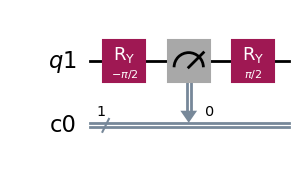

In [11]:
qr = QuantumRegister(1)
cr = ClassicalRegister(1)

circ = QuantumCircuit(qr,cr)
circ = measure_sx(circ,0,0)
circ.draw('mpl')

Recall that the measurement process takes the state of qubit and writes it to the classical register, which is just a blank set of slots (also initialized to zero). When we begin taking multiple measurements, we'll need to write to different slots on the classical register to record all the measurements.

But for now, this should do it. Let's see what happens. For simplicity, we'll run the simulator. One wrinkle is that the ```StatevectorSampler``` does not support so-called "mid-circuit measurements" (measurements which are followed by additional gates). We can get around this by using the ```qiskit-aer``` package, but this needs to be installed. On a command line using ```pip```, this is as simple as

```pip install qiskit-aer```

For more information, see the documentation for [Qiskit Aer](https://qiskit.github.io/qiskit-aer/).

In [13]:
nshots = 1024

from qiskit_aer import AerSimulator

# For execution
simulator = AerSimulator()
compiled_circuit = transpile(circ, simulator)
sim_result = simulator.run(compiled_circuit).result()
counts = sim_result.get_counts()

In [14]:
counts

{'0': 505, '1': 519}

This could also be run on actual hardware as follows.

In [16]:
service = QiskitRuntimeService(channel="ibm_quantum",token="ee69f80653e849ef260d4491a35f844f13aecd3cb351c65f654fc4fe74a83c45cf2a7de57836ffe3028c187f22d53f653b20f42493471d86dc75251fd0b25dd5")
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
backend.name

'ibm_kyiv'

In [17]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(circ)

#Execute using Qiskit primitives.
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

nshots = 1024
sampler = Sampler(backend)
job = sampler.run([(isa_circuit)],shots=nshots)

result = job.result()

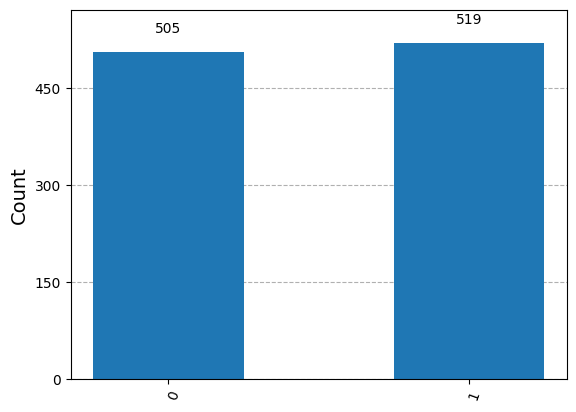

In [18]:
from qiskit.visualization import plot_histogram
plot_histogram([counts])

Recall that we need to interpet '0' or '1' as '+' or '-' <i>in this basis for which the measurment is performed</i>. We conclude that of all the spins initialized in $\left|+\right\rangle$, about half were measured to be $\left|+\right\rangle_{x}$ while the other half were measured to be in $\left|-\right\rangle_{-}$. So far nothing too magical.
    
Surely, measuring $\hat{S}^{z}$ one more time would return $+$ for all measurements since the state began in that eigenstate. We can explore this by adding another measurement. Since this will require a larger classical register to store two measurements, we'll just redo the circuit:

In [34]:
qr = QuantumRegister(1)
cr = ClassicalRegister(2,'c')

circ = QuantumCircuit(qr,cr)
circ = measure_sx(circ,0,1)
circ = measure_sz(circ,0,0)
circ.draw()

┌──────────┐┌─┐┌─────────┐┌─┐
q10: ┤ Ry(-π/2) ├┤M├┤ Ry(π/2) ├┤M├
     └──────────┘└╥┘└─────────┘└╥┘
c: 2/═════════════╩═════════════╩═
                  1             0

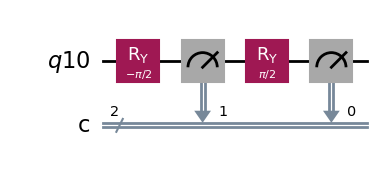

In [36]:
circ.draw("mpl")

One potentially confusing item (at least for me): It appears the the classical register state is written right-to-left. I tend to think left-to-right in most cases, so I have written the first measurement to ```cr[1]``` and the second to ```cr[0]```. It doesn't matter which measurement gets stored where, but (as of the time of writing this) this appears be necessary to get an output that can be read from left to right (but more on this below!). For completion, here is the Stern-Gerlach setup being used:

<img src="Mishrakishan/mishrakishan.github.io/assets/img/spins1.jpg" alt="sg2" width="600"/>

As before, the initialization on the backend takes care of the first $\hat{S}^{z}$ measurement. Note that the Stern-Gerlach experiment only feeds the $\left|+\right\rangle_{x}$ into the final analyzer. There is nothing in our quantum circuit that makes this restriction, but we will be able to account for this once we get the counts--the joys of post-processing!

So let's run this thing and see what happens:

In [20]:
nshots = 8192

# For execution
simulator = AerSimulator()
compiled_circuit = transpile(circ, simulator)
sim_result = simulator.run(compiled_circuit, shots = nshots).result()
counts = sim_result.get_counts()

This one is a little more interesting, so let's also give it a run on a real device.

In [21]:
service = QiskitRuntimeService(channel="ibm_quantum",token="Token Code")
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
backend.name

'ibm_kyiv'

In [22]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(circ)

#Execute using Qiskit primitives.
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

sampler = Sampler(backend)
job = sampler.run([(isa_circuit)],shots=nshots)

result = job.result()

In [23]:
from qiskit_ibm_runtime import QiskitRuntimeService

job = service.job('cyv1qa538jq0008xy0r0')
result = job.result()

In [24]:
counts_q = result[0].data.c.get_counts()

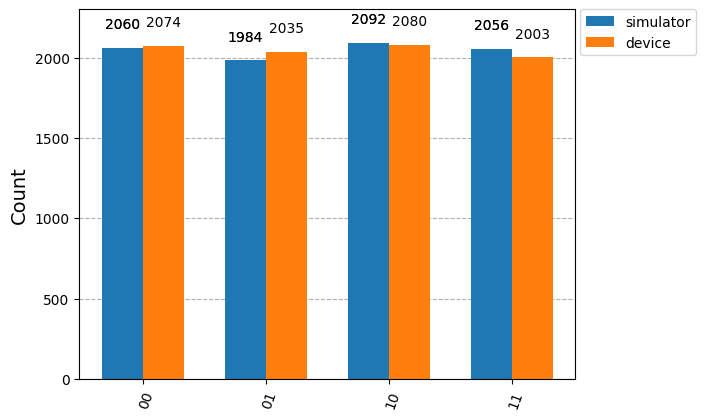

In [25]:
plot_histogram([counts,counts_q],legend=['simulator','device'])

Crudely, it looks like about a quarter of the initial $\left|+\right\rangle$ spins go into each state. There's a bit to unpack here, so let's do it carefully.

The classical register stores the outcomes ('0' or '1' in qubit language corresponding to '+' or '-' in spin language) of a single measurement. Our "counts" tell us all of the classical register states and how many times each was observed.

Let's start with '00'. In the spin language, this is '++'. But the register doesn't record the measurement direction, so we have to reintroduce that information when interpreting what it means. Recalling that we begin with a state $\left|+\right\rangle$, we measured $\hat{S}^{x}$ and then measured $\hat{S}^{z}$. Thus, the state labeled by '00' means the measurment of $\hat{S}^{x}$ returned +$\frac{\hbar}{2}$, projecting the system into the eigenstate $\left|+\right\rangle_{x}$, and the subsequent measurement of $\hat{S}^{z}$ resulted in $+\frac{\hbar}{2}$. Since the initialization <i>gave</i> us a state with $S^{z} = + \frac{\hbar}{2}$, this all seems quite reasonable.

But the <i>funny</i> business concerns the existence of states '01' and '11'. The second register element being '1' indicates that the $\hat{S}^{z}$ measurement returned $-\frac{\hbar}{2}$. This is bizarre because it's like observing that an apple is red, tasting it to find that it is sweet, and then looking to see that it is green. Well that's a sloppy analogy, but no analogy is perfect.


In [39]:
qr = QuantumRegister(1)
cr = ClassicalRegister(2)

circ = QuantumCircuit(qr,cr)
circ = measure_sz(circ,0,1)
circ = measure_sz(circ,0,0)
circ.draw()

# For execution
simulator = AerSimulator()
compiled_circuit = transpile(circ, simulator)
sim_result = simulator.run(compiled_circuit).result()
counts = sim_result.get_counts()

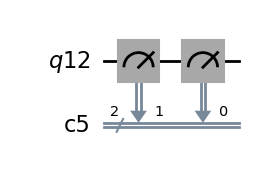

In [40]:
circ.draw("mpl")

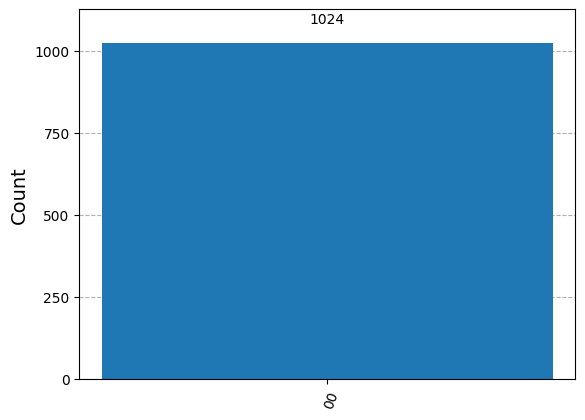

In [27]:
plot_histogram([counts])

Here we see that repeated measurements of $\hat{S}^{z}$ consistently return the same value. That is, '00' refers to repeated measurements of "+" whereas a reading of '01' would follow from a measurement of $S^{z}\rightarrow +\frac{\hbar}{2}$ followed by an immediate measurement of $S^{z}$ which yielded $-\frac{\hbar}{2}$. Given that '00' is essentially the only result (aside from noise, error), one can conclude that repeated measurements of $\hat{S}^{z}$ will give the same value.

It's only when a non-commuting observable is measured between successive measurements that different results are obtained.

<b>Exercise: </b> Instead of $\hat{S}^{z}$, try measuring $\hat{S}^{x}$ twice. Are the results the same as the previous case? Why or why not?

In [37]:
qr = QuantumRegister(1)
cr = ClassicalRegister(2)

circ = QuantumCircuit(qr,cr)
circ = measure_sx(circ,0,1)
circ = measure_sx(circ,0,0)
circ.draw()

# For execution
simulator = AerSimulator()
compiled_circuit = transpile(circ, simulator)
sim_result = simulator.run(compiled_circuit).result()
counts = sim_result.get_counts()

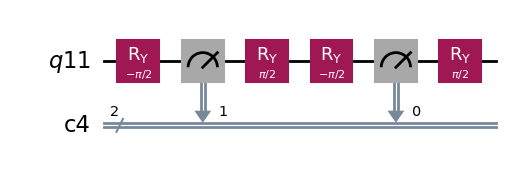

In [38]:
circ.draw("mpl")

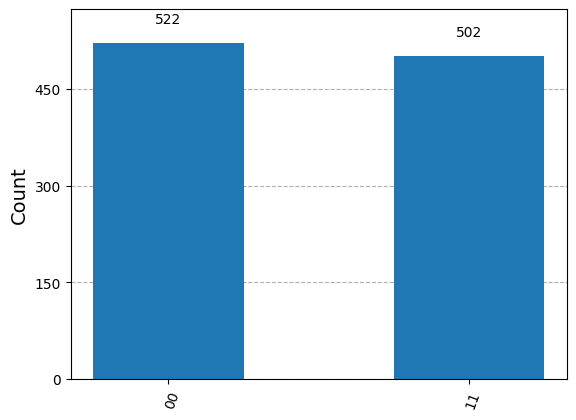

In [29]:
plot_histogram([counts])

From the histogram, we see that the measurements are roughly evenly divided between '00' and '11'. Recall that the circuit measures $\hat{S}^{x}$ twice given an initial state of $\left|+\right\rangle$. This splitting means that the initial state gives $S^{x} = \pm\frac{\hbar}{2}$ with roughly equal frequency upon the first measurement. The only states with any significant probability (at the end of the circuit) are '00' and '11', so we can say definitively that any of the initial spins which registered $S^{x} = + \frac{\hbar}{2}$ upon the first measurement also give the same value in the second measurement (and similar for $S^{x} = -\frac{\hbar}{2}$).

Given the results of the previous exercise, we can conclude that repeated measurements on an eigenstate (of that operator) will yield a consistent value for that observable. However, measuring <i>other</i> observables <i>can</i> destroy the notion of a well-defined value for the first observable.

<b>Technical note: </b> We will see again and again that two <i>commuting</i> operators have simultaneous eigenvalues, so we can assign well-defined values to both quantities. It's when the operators don't commute that we run into this quantum weirdness.

<b>Exercise</b>: Open the SPINS program and run the following simulation:

<img src="assets/img/spins1.jpg" alt="spins1" width="600"/>

Now construct a quantum circuit to simulate this case. Note that the Stern-Gerlach setup only <i>analyzes</i> the $\hat{S}^{x}$ states without recording a measurement. You can mimic this by modifying the function ```measure_sx()``` to ```analyze_sx()``` as follows:

```
def analyze_sx(circuit,qreg,creg):
    circuit.ry(-np.pi/2,qreg)
    #circuit.measure(qreg,creg)
    circuit.ry(np.pi/2,qreg)
    return circuit
```

This is sloppy programming, but it emphasizes that all you're changing is to delete the actual measurement. The rotation (and anti-rotation) still takes place and represents the "analyzing" done in the SPINS software.

Interpret your results.

<b>Solution:</b>

Here's the SPINS result for $N = 10^{4}$:

{% include figure.liquid loading="eager" path="Mishrakishan/mishrakishan.github.io/assets/img/spins2.jpg" class="img-fluid rounded z-depth-1" %}

Note that all of the selected spins from the first analuzer make it to $+\frac{\hbar}{2}$ in the final analyzer. To simulate this:

In [30]:
def analyze_sx(circuit,qreg,creg):
    circuit.ry(-np.pi/2,qreg)
    #circuit.measure(qreg,creg)
    circuit.ry(np.pi/2,qreg)
    return circuit

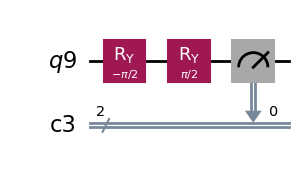

In [31]:
qr = QuantumRegister(1)
cr = ClassicalRegister(2)

circ = QuantumCircuit(qr,cr)
circ = analyze_sx(circ,0,1)
circ = measure_sz(circ,0,0)
circ.draw('mpl')

In [32]:
simulator = AerSimulator()
compiled_circuit = transpile(circ, simulator)
sim_result = simulator.run(compiled_circuit).result()
counts = sim_result.get_counts()

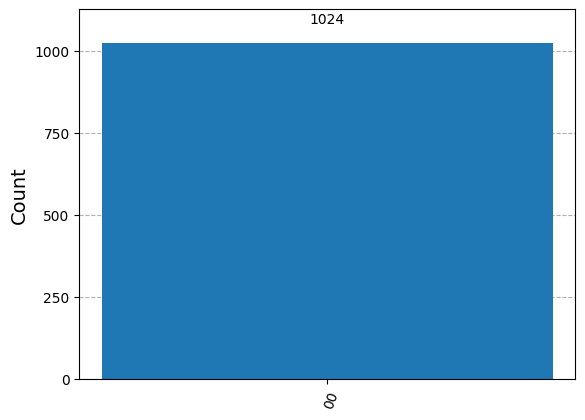

In [33]:
plot_histogram([counts])

Despite the rotations involved in "analyzing" the spin component, essentially all states still $\left|+\right\rangle$. It appears that the measurement of $\hat{S}^{x}$ is crucial in destroying the coherence of this initial state.